# Forecasting with delayed historical data

In the world of forecasting, accurate predictions depend on historical data. In many real-world scenarios, however, the available data is often subject to delays.  Consider the retail industry, where sales data often arrive with delays ranging from a few days to several weeks. Such delays pose significant challenges for autoregressive models, which use past values of the target variable as predictors.

One of the primary obstacles when working with delayed data is accurately evaluating model performance. Incorporating the delay into the evaluation becomes critical, as models must be evaluated based on the data available at the time of prediction. Failure to do so can lead to overly optimistic results, as the model may be accessing data that wasn't available during the prediction period.

One way to mitigate this challenge is to include lags that are greater than the maximum delay that the historical data can have. For example, if the data is delayed by 7 days, the minimum lag should be 7 days. This ensures that the model always has access to the data it needs to make predictions. However, this approach will not always achieve great results because the model may be using data that is too far in the past to be useful for prediction.

<p style="text-align: center">
<img src="../img/forecasting_with_delayed_historical_data.gif" style="width: 650px;">
<br>
<font size="2.5"> <i>Predictions with lags (last window available) greater than the maximum delay.</i></font>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

In [2]:
# Download data and preprocessing
# ==============================================================================
data = fetch_dataset(name='h2o', raw=True, verbose=False,
                     kwargs_read_csv={'header': 0, 'names': ['y', 'datetime']})

data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

print(f"Length of time series: {len(data)}")
print(f"Frequency: {data.index.freqstr}")
data.head(3)

Length of time series: 204
Frequency: MS


,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


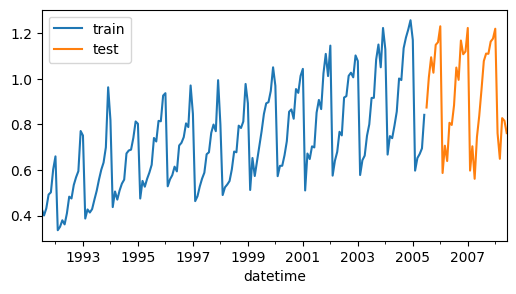

In [3]:
# Train-validation dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'
data_train = data[:end_train].copy()
data_test  = data[end_train:].copy()

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
ax.legend()
plt.show()

## Forecasting with delayed data

The data used in this example is a time series of monthly values. Let's assume that the data is delayed by 3 months. This means that the data for January will not be available until April, the data for February will not be available until May, and so on.

Ideally, we would like to forecast the entire next year using the last 12 months of data, starting with the month immediately preceding the forecast (lags 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, and 12). However, because the data are delayed by 3 months, it is not possible to use lags 1, 2, or 3 to predict the target variable because these data are not available at the time of the forecast. Therefore, the minimum lag must be 4.

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = [4, 5, 6, 7, 8, 9, 10, 11, 12] 
             )

forecaster.fit(y=data_train['y'])

Using a backtesting process, three years are forecast in batches of 12 months.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To a better understanding of backtesting process visit the <a href="https://skforecast.org/latest/user_guides/backtesting">Backtesting user guide</a>.

</div>

In [5]:
# Backtesting forecaster on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data_train),
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

metric

Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   No training in this fold
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   No training in this fold
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_absolute_error
0,0.065997


In [6]:
# Backtest predictions
# ==============================================================================
predictions.head(5)

,pred
2005-07-01,1.077316
2005-08-01,1.070779
2005-09-01,1.088995
2005-10-01,1.101434
2005-11-01,1.122724


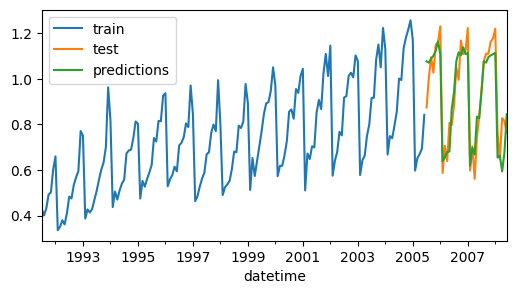

In [7]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Forecasting in production

Once the model has been validated, taking into account the delay, it can be used in production. In this case, the model will use the data available at the time of the forecast, which will be data starting 3 months ago. 

The way the model identifies the data to use is by position index. For example, lag 4 is the value at position 4 from the end of the last available window. The forecaster assumes that the last window provided ends just before the first step to be predicted, but because of the delay, the most recent data available will not be the most recent data in the time series. To ensure that the lags are taken from the correct position, the last window must be extended with dummy values. The number of dummy values must be equal to the number of steps between the last available data and the date just before the first forecast step. In this case, the lag is 3 months, so the number of dummy values must be 3.

Let's take a real example, first we train the model with all available data.

In [8]:
# Create and fit forecaster (whole data)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = [4, 5, 6, 7, 8, 9, 10, 11] 
             )

forecaster.fit(y=data['y'])

In [9]:
# Last window 
# ==============================================================================
last_window = forecaster.last_window
last_window

,y
datetime,
2007-08-01,1.078219
2007-09-01,1.110982
2007-10-01,1.109979
2007-11-01,1.163534
2007-12-01,1.176589
2008-01-01,1.219941
2008-02-01,0.761822
2008-03-01,0.649435
2008-04-01,0.827887


Our latest available data date is `2008-06-01` and, as we know we have a 3 months delay, this means that we are actually sometime in September (the time at which we want to make predictions) and our first predicted point will be `2008-10-01`.

Since the forecaster expects the last window to end in `2008-09-01` and the last available data is the `2008-06-01` value, the **last window must be extended by 3 dummy values**.

In [10]:
# Dummy values to complete the last_window until the moment of prediction
# ==============================================================================
# These dummy values are never used by the model because they are always posterior to the
# smallest lag.
date_start_prediction = pd.to_datetime("2008-09-30")
dummy_value = np.inf

last_window_extended = last_window.reindex(
    pd.date_range(start=last_window.index[0], end=date_start_prediction, freq='MS'),
    fill_value = dummy_value
)

last_window_extended

,y
2007-08-01,1.078219
2007-09-01,1.110982
2007-10-01,1.109979
2007-11-01,1.163534
2007-12-01,1.176589
2008-01-01,1.219941
2008-02-01,0.761822
2008-03-01,0.649435
2008-04-01,0.827887
2008-05-01,0.816255


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Dummy values are never used by the model because they are always posterior to the smallest lag.

</div>

In [11]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=12, last_window=last_window_extended)
predictions.head(3)

2008-10-01    1.107654
2008-11-01    1.182545
2008-12-01    1.153173
Freq: MS, Name: pred, dtype: float64

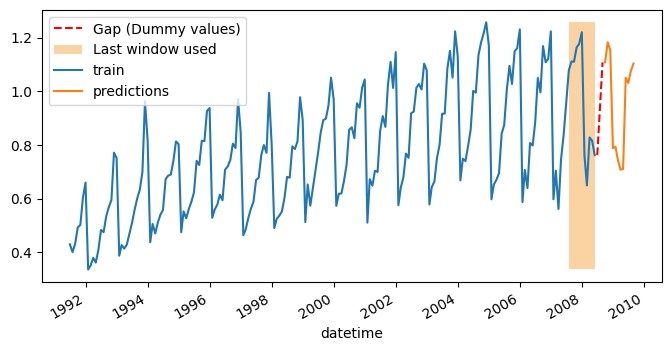

In [12]:
# Plot predictions
# ==============================================================================
last_window_used = (last_window_extended.index[0], last_window_extended.index[-4]) 
dummy_values = (last_window_extended.index[-3], last_window_extended.index[-1]) 

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    [dummy_values[0], dummy_values[1]],
    [last_window.iloc[-1, 0], predictions.iloc[0]],
    color = 'red',
    linestyle = '--',
    label = 'Gap (Dummy values)'
)
ax.fill_between(last_window_used, data['y'].min(), data['y'].max(), 
                facecolor='#f7931a', alpha=0.4, zorder=0, label='Last window used')
data['y'].plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show();

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Some forecasting models, such as <a href="https://skforecast.org/latest/user_guides/forecasting-sarimax-arima">ARIMA and SARIMAX</a>, do not have as much flexibility in terms of changing the last window values. In these cases, forecasts must be made from the last available data to the desired forecast horizon. The forecast values for the delayed data may be discarded as they are already past values.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

For a better understanding of how to deploy Forecaster models,  visit <a href="https://skforecast.org/latest/user_guides/forecaster-in-production">forecaster models in production</a>.

</div>